In [68]:
from amplify import gen_symbols, BinaryPoly
from amplify import sum_poly
from amplify.constraint import equal_to
import matplotlib.pyplot as plt
from amplify import Solver
from amplify.client import FixstarsClient
import matplotlib.ticker as ticker   
from amplify.client.ocean import DWaveSamplerClient
 
# t1, t2 = [int(i) for i in input().split()] # 競技プログラミングの場合は入力を受け取るときにこうする
t1, t2 = 0, 37 # 初期温度、目標温度
T = t2 - t1 # 初期温度と目標温度の差→初期温度と目標温度に依らず、この値が重要となる
N = 8 # リモコンを最大で何回操作するか→Tを大きくする場合は大きくする必要がある
R = [0, -1, 1, -5, 5, -10, 10] # リモコンの機能

use_equal_to = False # equal_to関数を使うかどうか

Len_R = len(R) # リモコンで変化できる温度の種類→ループを回す際に必要

# QUBOの各項に掛ける係数
A = 1
B = 250
C = 0.99

q = gen_symbols(BinaryPoly, N*Len_R)


if use_equal_to == True:
    # QUBO1 ペナルティ項（変化した温度の総和がTとなる）-------------------------------------------------
    constraints1 = [equal_to(sum_poly([R[i%Len_R] * q[i] for i in range(N*Len_R)]), T)]
    constraints1 *= A # 制約条件の強さを設定
    constraints1 = sum(constraints1)
    
    # QUBO2 ペナルティ項（リモコンの操作は１度に１回）--------------------------------------------------
    constraints2 = []
    for i in range(N):   
        constraints2 += [equal_to(sum_poly([q[j%Len_R + Len_R * i] for j in range(Len_R)]), 1)]
    constraints2 *= B # 制約条件の強さを設定
    constraints2 = sum(constraints2)

else:
    # QUBO1 ペナルティ項（変化した温度の総和がTとなる）-------------------------------------------------
    constraints1 = A * (sum_poly([R[i%Len_R] * q[i] for i in range(N*Len_R)]) - T) ** 2

    # QUBO2 ペナルティ項（リモコンの操作は１度に１回）--------------------------------------------------
    constraints2 = 0
    for i in range(N):   
        constraints2 += B * (sum_poly([q[j%Len_R + Len_R * i] for j in range(Len_R)]) - 1) ** 2

        
# QUBO3 0度を選んだらほんの少しだけご褒美を与える---------------------------------------------------
# 「最小の回数」を出力するために必要な条件
# 温度がTに出来る操作の組合せのうち、0℃を多く選んだものを評価できるように
reward = sum_poly([-C * q[Len_R * i] for i in range(N)])

# QUBO = QUBO1 + QUBO2 + QUBO3
model = constraints1 + constraints2 + reward         
        

結果（0℃変更含む）
[0, 0, 0, 0, 0, 0, 0, 1] 0℃変更
[0, 0, 1, 0, 0, 1, 0, 0] -1℃変更
[0, 0, 0, 1, 0, 0, 1, 0] 1℃変更
[0, 0, 0, 0, 0, 0, 0, 0] -5℃変更
[0, 0, 0, 1, 1, 0, 1, 0] 5℃変更
[0, 0, 0, 0, 0, 0, 0, 0] -10℃変更
[1, 1, 0, 0, 0, 0, 0, 0] 10℃変更
--------------------------
結果（0℃変更含まない）
[0, 0, 1, 0, 0, 1, 0] -1℃変更
[0, 0, 0, 1, 0, 0, 1] 1℃変更
[0, 0, 0, 0, 0, 0, 0] -5℃変更
[0, 0, 0, 1, 1, 0, 1] 5℃変更
[0, 0, 0, 0, 0, 0, 0] -10℃変更
[1, 1, 0, 0, 0, 0, 0] 10℃変更
--------------------------


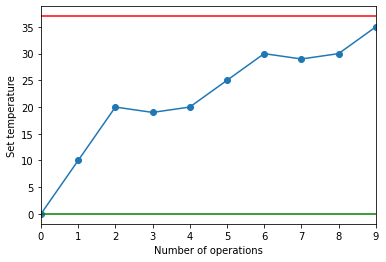

操作回数 9


<Figure size 432x288 with 0 Axes>

In [69]:
use_dwave = True


# 計算実行------------------------------------------------------------------------------------------

if use_dwave == True:
    client = DWaveSamplerClient()
    with open("tokenfile_dwave.txt", "r") as f:
        token = f.readline()
    client.token = token
    client.solver = "Advantage_system1.1"
    client.parameters.num_reads = 100

else:
    client = FixstarsClient()
    with open("tokenfile.txt", "r") as f:
        token = f.readline()
    client.token = token
    client.parameters.timeout = 500  # タイムアウト5秒
    
solver = Solver(client)

result = solver.solve(model)
if len(result) == 0:
    raise RuntimeError("Any one of constraints is not satisfied.")

energy, values = result[0].energy, result[0].values


# 結果表示------------------------------------------------------------------------------------------
print("結果（0℃変更含む）")
for i in range(Len_R):
    print([values[j*Len_R + i] for j in range(N)],"{}℃変更".format(R[i]))
print("--------------------------")

print("結果（0℃変更含まない）")
non_zero_list = []
for j in range(N):
    if values[j*Len_R] == 0:
        non_zero_list.append(j)

for i in range(1, Len_R):
    print([values[j*Len_R + i] for j in non_zero_list],"{}℃変更".format(R[i]))
print("--------------------------")


# グラフ描写----------------------------------------------------------------------------------------
path = [t1]
for j in range(N):
    for i in range(Len_R):
        if i != 0:
            temp = R[i] * values[j*Len_R + i]
            if temp != 0:
                path.append(temp + path[-1])
                       
fig = plt.figure()
x = [i for i in range(len(path))]
plt.scatter(x, path)  
plt.plot(x, path)
plt.plot([-1, 10000], [t1, t1], color="green")
plt.plot([-1, 10000], [t2, t2], color="red")
plt.xlim([0, len(path)-1])
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().get_yaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel('Number of operations')
plt.ylabel('Set temperature')

plt.show()
plt.savefig("img.png")

# 設定したNが操作回数に対して大きすぎる場合は、最小操作回数となっていない可能性が増えてしまうため、
# 適宜Nを小さくする必要があるかもしれない
print("操作回数", len(path)-1)
